### Perceptron Algorithm

Write a programm that implements the perceptron algorithm and test the running time and the probability of error of the resulting linear classifier. Test it on both linearly seperable and non-seperable data.

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import seaborn as sns
import itertools
from multiprocessing import Pool
import matplotlib.pyplot as plt
from scipy.stats import norm

#### Perceptron Algorithm and helper functions

In [2]:
# Perceptron Algorithm # 
class Perceptron():
    
    def __init__(self,d):
        self.w = np.zeros(d)
        self.w_hist = []
        self.rounds = 0
        self.w_hist.append(self.w)
        self.d = d
        self.errorDelta = 1
    
    # Function for predicting
    def predict(self,X):
        
        prediction= np.sign(np.dot(self.w,X.T))
        return prediction
    
    # Function for fitting
    def fit(self,X,y, precision = 0.01, max_rounds = 2000):
        
        # Scale the data, otherwise convergence wouldn't be bounded
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
        # Set to starting values again (in case it has been fitted before)
        self.w = np.zeros(self.d)
        self.w_hist = []
        self.rounds = 0
        self.w_hist.append(self.w)
        
        # Intitial value for current score
        self.errorDelta = precision +1
        currentScore = accuracy_score(y,self.predict(X))
        
        # Loop following the udpate rule
        while any(self.predict(X) != np.sign(y)) and abs(self.errorDelta) > precision and self.rounds <= max_rounds :
            
            # Set current score to previous score
            previousScore = currentScore
            
            # Go through the data
            for i in range(len(X)):    
                if self.predict(X[i]) != np.sign(y[i]):
                    
                    # Update the w
                    self.w = self.w + y[i]*X[i]
                    
                    # Store w in the list for tracing later
                    self.w_hist.append(self.w)
                    
                    # Update rounds
                    self.rounds +=1
            
            # Save current score 
            currentScore = accuracy_score(y,self.predict(X))
            
            # Save difference 
            self.errorDelta = currentScore - previousScore

In [3]:
# DGP for seperable data 
def generateDataSep(n,d,a):
    # Generate Y values
    y = np.array([-1 if y < 0.5 else 1 for y in np.random.uniform(0,1,n)])

    # Generating first x entry
    x1 = np.zeros(n)

    # Assigning first entries in the vector according to conditional probabilities 
    x1[y == 1] = np.random.uniform(-1,-a,len(x1[y == 1]))
    x1[y == -1] = np.random.uniform(a,1,len(x1[y == -1]))

    # Generate rest of x values according to uniform from -1 to 1
    x_rest = np.random.uniform(-1,1,n*(d-1))

    # Bind together
    X = np.concatenate((x1.reshape(n,1),x_rest.reshape(n,d-1)), axis = 1 )
    
    # Return
    return X,y

# DGP for non-seperable data
def generateDataNonSep(n,d,m):
    
    m = np.array([m])
    
    # Mean vectors and covariance matrix
    mean_y_pos = np.concatenate((m,np.zeros(d-1)))
    mean_y_neg = np.zeros(d)
    covariance = np.identity(d)

    # Generate Y values
    y = np.array([-1 if y < 0.5 else 1 for y in np.random.uniform(0,1,n)])

    # Sort, makes merging with x values easier
    y.sort()

    # Generating features 
    x_neg = np.random.multivariate_normal(mean_y_neg,covariance,sum(y==-1))
    x_pos = np.random.multivariate_normal(mean_y_pos,covariance,sum(y==1))

    # Merging together
    X = np.vstack((x_neg,x_pos))

    # Shuffle
    X, y = shuffle(X, y)

    return X, y

# Helper for visualizing convergence
def plot_rounds(area,figsize,perceptron,X,y,to_plot,plot_param,save = False,):
    
    figsize = (10,8)
    
    for i in to_plot:
            fig, ax = plt.subplots(figsize=figsize)
    
            # Make meshgrid
            xx, yy = np.mgrid[area[0]:area[1]: 0.01, area[0]:area[1]: 0.01]
            grid = np.c_[xx.ravel(), yy.ravel()]

            boundary = np.array([perceptron.w_hist[i] @ xy for xy in grid]).reshape(xx.shape)
    
            # Make figure and plot
            contour = ax.contourf(xx, yy, boundary, 1, colors = ["grey","white"])

    
            # Scatter data points, color by class
            ax.scatter(X[::,0], X[::, 1], c=y, cmap="RdBu",edgecolor="white", linewidth=1)    
    
            # Set ax labels
            ax.set(xlabel="$X_1$", ylabel="$X_2$")
            ax.set_ylim(area[0],area[1])
            ax.set_xlim(area[0],area[1])
            #fig.suptitle(f"Round {i}",fontsize = 20);
            
            if save:
                    fig.savefig(f"../01_Figures/R2_Convergence/Perceptron_{plot_param}_round_{i}.jpg", dpi=80)

### Showing decision boundary and convergence in $R^2$

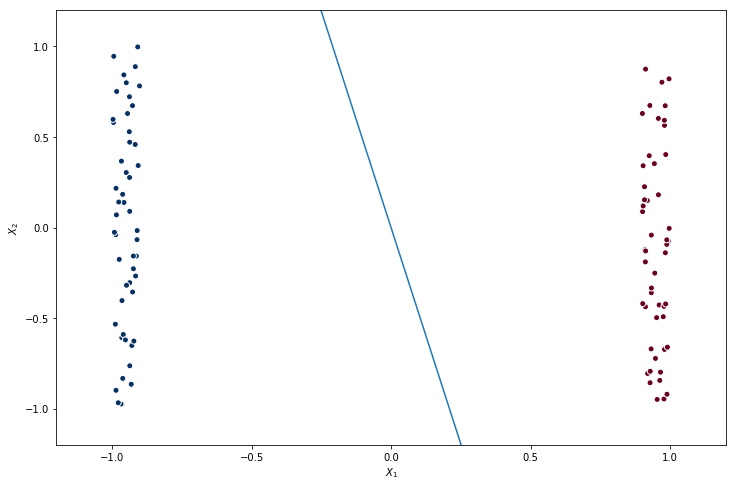

In [6]:
figsize = (12,8)
fig, ax = plt.subplots(figsize=figsize)
    
# Scatter data points, color by class
ax.scatter(X[::,0], X[::, 1], c=y, cmap="RdBu",edgecolor="white", linewidth=1)    

# Set ax labels
ax.set(xlabel="$X_1$", ylabel="$X_2$")
ax.set_ylim(area[0],area[1])
ax.set_xlim(area[0],area[1])

z = np.linspace(-1,1,100)

ax.plot(z,z*(-perceptron.w[0]/perceptron.w[1]))

In [7]:
perceptron.w[0]

-0.9612853551574111

Total Rounds: 1


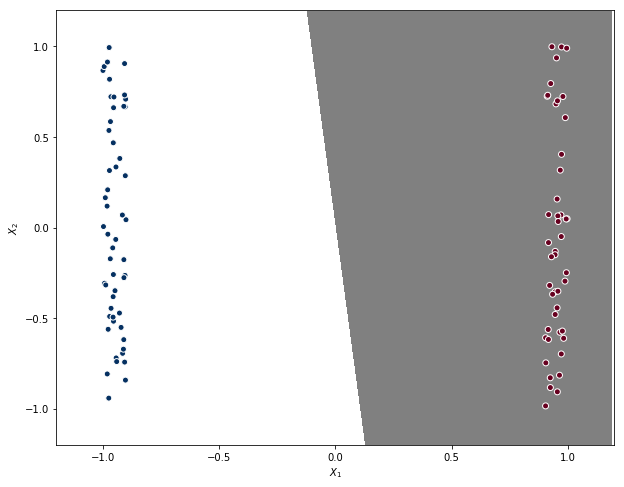

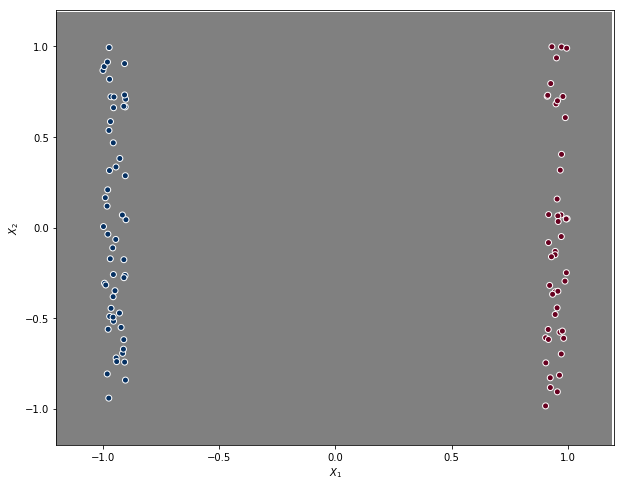

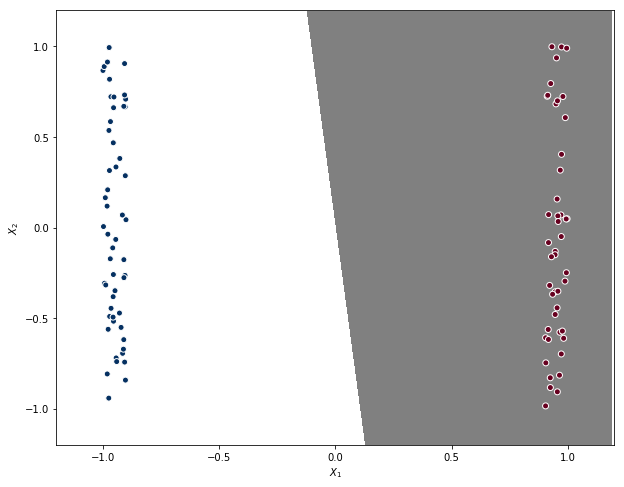

In [8]:
# Number of points n
n = 100

# Dimensionality of data 
d = 2

# Margin
a = 0.9

# Generate Data
X,y = generateDataSep(n,d,a)

# Instatitate the perceptron
perceptron = Perceptron(d)

# Fit
perceptron.fit(X,y)

# Plotting params
area = [-1.2,1.2]
figsize = (12,8)

to_plot = [1,int(perceptron.rounds * 0.5),perceptron.rounds]

print(f"Total Rounds: {perceptron.rounds}")

# Plot
plot_rounds(area,figsize,perceptron,X,y,to_plot,plot_param="a_0.5",save=False)

### Simulating convergence and probability of error depending on $a$, $d$ and sample sizes.

In [96]:
def simulateSeperable(n,d,rounds,margins,testing_n):
    
    # Workaround for the plotting issue when running in parallel
    import matplotlib.pyplot as plt
    
    # Define classifier
    perceptron = Perceptron(d)

    # For storing results
    resulting_rounds = []
    resulting_risk = []

    for a in margins:

        temp_rounds = []
        temp_risk = []

        for sim in range(rounds):

            # Generate Data
            X,y = generateDataSep(n,d,a)

            # Store R (maximum norm of data (after scaling))
            scaler = StandardScaler()
            temp_R = np.max([np.linalg.norm(x) for x in scaler.fit_transform(X)])

            # Testing data
            test_X, test_y = generateDataSep(testing_n,d,a)

            # Fit
            perceptron.fit(X,y)

            # Predict
            predictions = perceptron.predict(scaler.transform(test_X))

            # Store accuracy and nr. of rounds
            temp_rounds.append(perceptron.rounds)
            temp_risk.append(1-accuracy_score(test_y,predictions))

        # Save average per a
        resulting_rounds.append(np.mean(temp_rounds))
        resulting_risk.append(np.mean(temp_risk))
        
    # Plot everything
    fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(14,6))
    
    
    # Plot Nr of rounds
    sns.lineplot(x= margins, y = resulting_rounds, ax = ax[0])
    ax[0].set_ylabel("Iterations",fontsize=20)
    ax[0].set_xlim(left=0, right = 1)
    ax[0].tick_params(labelsize=15)
    ax[0].set_xlabel("Margin", fontsize = 20)

    # Plot accuracy
    sns.lineplot(x= margins, y= resulting_risk, ax = ax[1])
    ax[1].set_ylabel("Empirical Risk",fontsize=18)
    ax[1].set_xlim(left=0, right = 1)
    ax[1].tick_params(labelsize=15)
    ax[1].set_xlabel("Margin", fontsize = 20)

    # Save figures
    fig.suptitle(f"Sample Size = {n}, Dimension = {d}",fontsize = 20);
    fig.savefig(f"../01_Figures/Perceptron_Seperable{n}_d{d}", dpi=80)

In [97]:
%%time

## Simulate in parallel ##

# Simulations rounds
rounds = 400

# Value for n
sample_sizes = [100,200,500]

# Dimensions
dimensions = [2,10,100]

# Margins
margins = np.arange(0.,1,0.05)

# Testing data
testing_n = 400

# Combine the two to iterate over
combinations = list(itertools.product(sample_sizes, dimensions))

# Execute in Parallel
pool = Pool(processes=4)

# Submit jobs in parallel
results = [pool.apply_async(simulateSeperable, args=(comb[0],comb[1],rounds,margins,testing_n)) for comb in combinations]
output = [p.get() for p in results]
print(output)
pool.close()


[None, None, None, None, None, None, None, None, None]
CPU times: user 391 ms, sys: 158 ms, total: 549 ms
Wall time: 7min 23s


### Simulating non-seperable case

Total Rounds: 20,


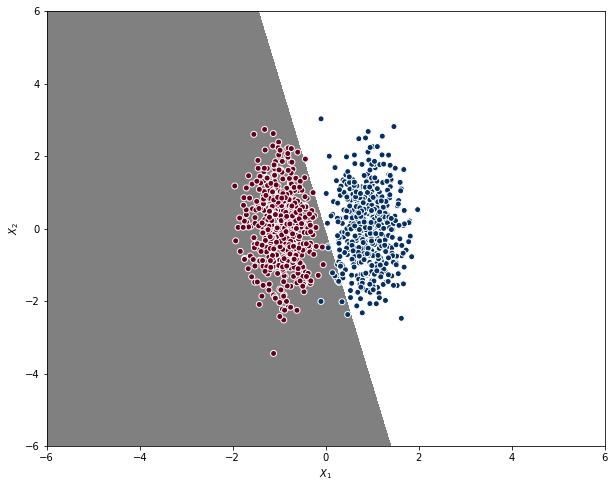

In [10]:
# Example 
n = 1000
m = 5
d =2

X,y = generateDataNonSep(n,d,m)

# Instatitate the perceptron
perceptron = Perceptron(d)

# Fit
perceptron.fit(X,y,precision=0.0000001,max_rounds=2000)

# Plotting params
area = [-6,6]
figsize = (12,8)

#to_plot = [1,int(perceptron.rounds * 0.5),perceptron.rounds]
to_plot = [perceptron.rounds]

print(f"Total Rounds: {perceptron.rounds},")

scaler = StandardScaler()

# Plot
plot_rounds(area,figsize,perceptron,scaler.fit_transform(X),y,to_plot,plot_param="SCALE",save=True)

Defining function for simulating non-seperable case

In [92]:
def simulateNonSeperable(n,d,rounds,firstMeans,testing_n):
    
    # Workaround for the plotting issue
    import matplotlib.pyplot as plt

    # Define classifier
    perceptron = Perceptron(d)

    # For storing results
    resulting_rounds = []
    resulting_risk = []

    for m in firstMeans:

        temp_rounds = []
        temp_risk = []

        for sim in range(rounds):

            # Generate Data
            X,y = generateDataNonSep(n,d,m)

            # Testing data
            test_X, test_y = generateDataNonSep(testing_n,d,m)

            # Fit
            perceptron.fit(X,y,precision=0.001,max_rounds = 2000)

            # Predict
            predictions = perceptron.predict(scaler.fit_transform(test_X))

            # Store accuracy and nr. of rounds
            temp_rounds.append(perceptron.rounds)
            temp_risk.append(1-accuracy_score(test_y,predictions))

        # Save average per a
        resulting_rounds.append(np.mean(temp_rounds))
        resulting_risk.append(np.mean(temp_risk))
        
    
    bayes_risk = [norm.cdf(m/2,loc = m, scale = 1 ) for m in firstMeans]


    # Plot everything
    fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(14,6))

    # Plot Nr of rounds
    sns.lineplot(x= firstMeans, y = resulting_rounds, ax = ax[0], label ="Iterations")
    ax[0].set_ylabel("Iterations",fontsize=20)
    ax[0].set_xlim(left=0, right = np.max(firstMeans))
    ax[0].tick_params(labelsize=15)
    ax[0].set_xlabel("$m$", fontsize = 20)
    ax[0].legend(fontsize = 20, frameon=False)

    # Plot accuracy
    sns.lineplot(x= firstMeans, y= resulting_risk, ax = ax[1],label = "Perceptron Risk")
    sns.lineplot(x= firstMeans, y  = bayes_risk, ax = ax[1] , label = "Bayes Risk")
    ax[1].set_ylabel("Risk",fontsize=18)
    ax[1].set_xlim(left=0, right = np.max(firstMeans))
    ax[1].tick_params(labelsize=15)
    ax[1].set_xlabel("$m$", fontsize = 20)
    ax[1].legend(fontsize = 20, frameon=False)
    
    # Save figures
    fig.suptitle(f"Sample Size = {n}, Dimension = {d}",fontsize = 20);
    fig.savefig(f"../01_Figures/Perceptron_Non_Seperable{n}_d{d}", dpi=80)
    

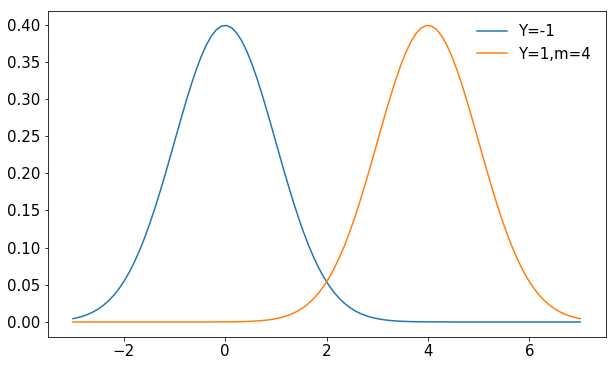

In [117]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize= (10,6))

m = 4
xVals = np.linspace(-3,m+3,100)
sns.lineplot(x = xVals, y = [norm.pdf(x,loc = 0, scale = 1 ) for x in xVals], ax=ax, label = "Y=-1")
sns.lineplot(x = xVals, y = [norm.pdf(x,loc = m, scale = 1 ) for x in xVals], ax=ax, label = f"Y=1,m={m}")
ax.tick_params(labelsize=15)
ax.legend(fontsize = 15, frameon=False);
fig.savefig(f"../01_Figures/Bayes_Risk", dpi=80)

In [98]:
[norm.cdf(0,loc = m/2, scale = 1 ) for m in firstMeans]

[0.5,
 0.3085375387259869,
 0.15865525393145707,
 0.06680720126885807,
 0.022750131948179195,
 0.006209665325776132,
 0.0013498980316300933,
 0.00023262907903552502,
 3.167124183311986e-05,
 3.3976731247300535e-06]

In [99]:
[norm.cdf(m/2,loc = m, scale = 1 ) for m in firstMeans]

[0.5,
 0.3085375387259869,
 0.15865525393145707,
 0.06680720126885807,
 0.022750131948179195,
 0.006209665325776132,
 0.0013498980316300933,
 0.00023262907903552502,
 3.167124183311986e-05,
 3.3976731247300535e-06]

In [93]:
%%time

## Simulate in parallel ##

# Simulations rounds
rounds = 400

# Value for n
sample_sizes = [100,200,500]

# Dimensions
dimensions = [2,10,100]

# Margins
firstMeans = np.arange(0,10,1)

# Testing data
testing_n = 400

# Combine the two to iterate over
combinations = list(itertools.product(sample_sizes, dimensions))

# Execute in Parallel
pool = Pool(processes=4)

# Submit jobs in parallel
results = [pool.apply_async(simulateNonSeperable, args=(comb[0],comb[1],rounds,firstMeans,testing_n)) for comb in combinations]

output = [p.get() for p in results]
print(output)
pool.close()


[None, None, None, None, None, None, None, None, None]
CPU times: user 625 ms, sys: 237 ms, total: 862 ms
Wall time: 11min 19s
